# **Cell nuclei detection by Stardist 2D**
---

**Stardist** is deep-learning method that can be used to segment cell nuclei in 2D (xy) single images or in stacks (xyz). 

*Disclaimer*:

This notebook is part of the Zero-Cost Deep-Learning to Enhance Microscopy project (https://github.com/HenriquesLab/DeepLearning_Collab/wiki). Jointly developed by the Jacquemet (link to https://cellmig.org/) and Henriques (https://henriqueslab.github.io/) laboratories.

This notebook is largely based on the paper:

[Cell Detection with Star-convex Polygons](https://arxiv.org/abs/1806.03535)

Uwe Schmidt, Martin Weigert, Coleman Broaddus, and Gene Myers.
International Conference on Medical Image Computing and Computer-Assisted Intervention (MICCAI), Granada, Spain, September 2018.

[Star-convex Polyhedra for 3D Object Detection and Segmentation in Microscopy](https://arxiv.org/abs/1908.03636)

Martin Weigert, Uwe Schmidt, Robert Haase, Ko Sugawara, and Gene Myers. arXiv, 2019

**The Original code** is freely available in GitHub:
https://github.com/mpicbg-csbd/stardist

**Please also cite this original paper when using or developing this notebook.**


# **How to use this notebook?**
---

###**Table of contents, Code snippets** and **Files**

On the left side of the notebook you find three tabs which contain from top to bottom the table of contents, code snippets and files

*Table of contents* = contains structure of the notebook. Click the content to move quickly between sections.

*Code snippets* = contain examples how to code certain tasks. You can ignore this when using this notebook.

*Files* = contain all available files. After mounting your google drive (see section 1.) you will find your files and folders here. 

**Remember that all uploaded files are purged after changing the runtime.** All files saved in Google Drive will remain. You do not need to use the Mount Drive-button; your Google Drive is connected in section 1.2.

**Note:** The "sample data" in "Files" contains default files. Do not upload anything here!

---
###**Text** and **Code Cells**

**Text cells** provide information and can be modified by douple-clicking the cell. You are currently reading the text cell. You can create a new text by clicking `+ Text`.

**Code cells** contain code and the code can be modfied by selecting the cell. To execute the cell, move your cursor on the `[ ]`-mark on the left side of the cell (play button appear). Click to execute the cell. After execution is done the animation of play button stops. You can create a new coding cell by clicking `+ Code`.

---
###**Making changes to the notebook**

**Please make a copy** of the notebook and save it to your Google Drive if you make changes. To do this click file -> save a copy in drive.

To **edit a cell**, double click on the text. This will show you either the source code (in code cells) or the source text (in text cells).
It is advisable to use the `#`-mark in code cells. This allows you to keep the original code piece in the cell as a comment.

**For example:**

Original code: all lines are excuted

`my_files = 2`

`my_mask = "names of masks"`

Modified code: the 1st line is not executed, but the 2nd and 3rd line are.

`#my_files = 2`

`my_files = 200`

`my_mask = "names of masks"`

# **The common workflow**

---
**If you wish to train a network and predict single images:**

Go sections: 1-3 (setup) 4 (training) and 5 (prediction)

**If you wish to train a network and predict stacks (for instance live cell imaging data):**

Go sections: 1-3 (setup) 4 (training) and 6 (prediction)

**If you already have a trained network and want to predict images:**

Go sections: 1-3 (setup) and 5 (prediction of single images) or 6 (prediction of stacks)

---


#**0. Before getting started**
---
<font size = 4>

1. Create the following folder tree in your Google Drive:

*   Experiment A
    - train
      - images
        - img_1.tif, img_2.tif, ...
      - Masks
        - img_2.tif, img_2.tif, ...
    - prediction 
    - results

2. Corresponding images and masks must have the **same name**.
3. Place all your test images in the **prediction** folder. Use only tif files!
4. **results** - folder will contain the predicted ROI, trained model and training values as csv file. Your original images remain in the test-folder and unmodified.

**Use only .tif files!**
---

# **1. Set the Runtime type and mount your Google Drive**

---






### **1.1 Change the Runtime**

Go to **Runtime -> Change the Runtime type**

**Runtime type: Python 3** *(Python 3 is programming language in which this program is written)*

**Accelator: GPU** *(Graphics processing unit (GPU)*


### **1.2. Mount your Google Drive**



In [0]:
#@markdown ###Play the cell to Mount your Google Drive.

#@markdown * Click on the URL. 

#@markdown * Sign in your Google Account. 

#@markdown * Copy the authorization code. 

#@markdown * Enter the authorization code. 

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive". 

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# **2. Install Stardist**
---


In [0]:
#@markdown ###Install Stardist and dependencies

%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)
print("Tensorflow enabled.")

# Install packages which are not included in Google Colab

!pip install tifffile # contains tools to operate tiff-files
!pip install csbdeep  # contains tools for restoration of fluorescence microcopy images (Content-aware Image Restoration, CARE). It uses Keras and Tensorflow.
!pip install stardist # contains tools to operate STARDIST.

# Import libraries needed to perform notebook
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
from pathlib import Path
import os
import numpy as np # collection of matematical operations
import matplotlib.pyplot as plt # tools for creating figures and plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from glob import glob # program can read path names 
from tqdm import tqdm # imports tools to create progress meter
from tifffile import imread # program can open and read tiff-files
from csbdeep.utils import Path, normalize, download_and_extract_zip_file, plot_history # for loss plot
from csbdeep.io import save_tiff_imagej_compatible

# import stardist
from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available, relabel_image_stardist, random_label_cmap,  relabel_image_stardist, _draw_polygons, export_imagej_rois
from stardist.models import Config2D, StarDist2D, StarDistData2D # import objects
from stardist.matching import matching_dataset
np.random.seed(42)
lbl_cmap = random_label_cmap()



1.15.0
Tensorflow enabled.
     |████████████████████████████████| 133kB 6.8MB/s 
     |████████████████████████████████| 18.1MB 190kB/s 
     |████████████████████████████████| 71kB 4.5MB/s 
     |████████████████████████████████| 399kB 7.1MB/s 
  Created wheel for stardist: filename=stardist-0.4.1-cp36-cp36m-linux_x86_64.whl size=1845487 sha256=139f9cb87c0b218074a3b67484c4527792eb5cebbfac052226efb2e043bab859
  Stored in directory: /root/.cache/pip/wheels/46/be/f5/1f4594371043e621355a621ac6d825d61c6837ce550f35a104
Successfully built stardist


Using TensorFlow backend.


# **3. Select your parameters and paths**

**What to do:** Enter the following paths and parameters. Copy the reguired path from the left from "Files" (right-click) to form right side of the cell. DO NOT TOUCH THE CODE! **Finally, play the cell to load information to the Stardist**.

**`prediction`:** Enter path of the folder containing your training images.

**`results`:** Enter a path for your results.

**`training`:** Enter path of the folder containing your training images. If you already have trained networks, leave this untouched (Stardist uses pretrained model).

**`masks`:** Enter path of the folder containing your mask images. If you already have trained networks, leave this untouched (Stardist uses pretrained model).

**`epochs`:** Input number of epochs in the networks. Original Stardist network is trained wth 400 epochs. If you already have trained networks, leave this untouched (Stardist uses pretrained model).

**`steps`:** Input number of steps in each epoch. Original Stardist network is trained with 100 steps. If you already have trained networks, leave this untouched (Stardist uses pretrained model).

**`modelpath`:** Enter path of the folder containing your model to-be-trained or pretrained model. All pretrained and will-be trained models are here (see Section 1). 

**`name`:** Name of you model. Use only my_model -style, not my-model.  If you already have trained networks, enter the name of the pretrained model (the name of the folder which is in trained_model -folder, includes all files of pretrained networks).

**`n_rays`:** Set number of rays (corners) used for Stardist (like square has 4 corners). 32 is a good default.

In [0]:
#@markdown ###Path to training images: 
training = "/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/Stardist/Training data/train/images" #@param {type:"string"}
training_images = training
masks = "/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/Stardist/Training data/train/masks" #@param {type:"string"}
mask_images = masks 


#@markdown ###Path to predicted images and results:
prediction = "/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/Stardist/Training data/prediction/test_stacks" #@param {type:"string"}
test_dataset = prediction
#test_batch = "/content/drive/Shared drives/Jacquemet Lab/Lab Projects/Zero Cost AI/Dataset/Nuclei pictures Others" #@param {type:"string"}

results = "/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/Stardist/Training data/results" #@param {type:"string"}

#@markdown ### Model name and path:
modelname = "50s_100e_GPU_GJ3" #@param {type:"string"}
model_name = modelname
modelpath = "/content/drive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/Stardist/Experiment_A1/results" #@param {type:"string"}
trained_model = modelpath 

#@markdown ### Other parameters for training:
epochs = 50 #@param {type:"number"}
input_epochs = epochs
steps = 50 #@param {type:"number"}
input_steps = steps

n_rays = 32 #@param {type:"number"}

# Here we add "/*.tif" script to the end of the path
# -> funtion "glob" (in 5.3) regonzises all tiff-files
# in that folder

# training
training_images=training_images+"/*.tif"
mask_images=mask_images+"/*.tif"
#single images
testDATA = test_dataset
test_dataset=test_dataset+"/*.tif"
#stack images
#test_batch_path=test_batch
#test_batch=test_batch+"/*.tif"




#**4. Train your network**

### **4.1. Prepare the training data and model for training**
<font size = 4>Here, we use the information from 3. to build the model and convert the training data into a suitable format for training.

In [0]:
#@markdown ###Create the model and dataset objects

# this funtion imports training images and masks and sorts them suitable for the network
X = sorted(glob(training_images))   
Y = sorted(glob(mask_images))   

# assert -funtion check that X and Y really have images. If not this cell raises an error
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))
!cat /proc/meminfo | grep 'MemAvailable'

# Here we map the training dataset (images and masks).

X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

#Normalize images and fill small label holes.
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

#Here we split the your training dataset into training images (90 %) and validation images (10 %). 
#It is advisable to use 10 % of your training dataset for validation. This ensures the truthfull validation error value. If only few validation images are used network may choose too easy or too challenging images for validation. 
# split training data (images and masks) into training images and validation images.
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)

#here we limit GPU to 80%
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)


# Here we create a model according to section 5.3.
model = StarDist2D(conf, name=model_name, basedir=trained_model)
!cat /proc/meminfo | grep 'MemAvailable'

#Here we check the FOV of the network.
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")



MemAvailable:   12321112 kB


100%|██████████| 30/30 [00:01<00:00, 27.61it/s]

number of images:  30
- training:        26
- validation:       4







Using default values: prob_thresh=0.5, nms_thresh=0.4.
MemAvailable:   12245544 kB








### **4.2. Inspecting training data**

<font size = 4>Here, we show one of the image and associated masks that will be used for training the network.
---



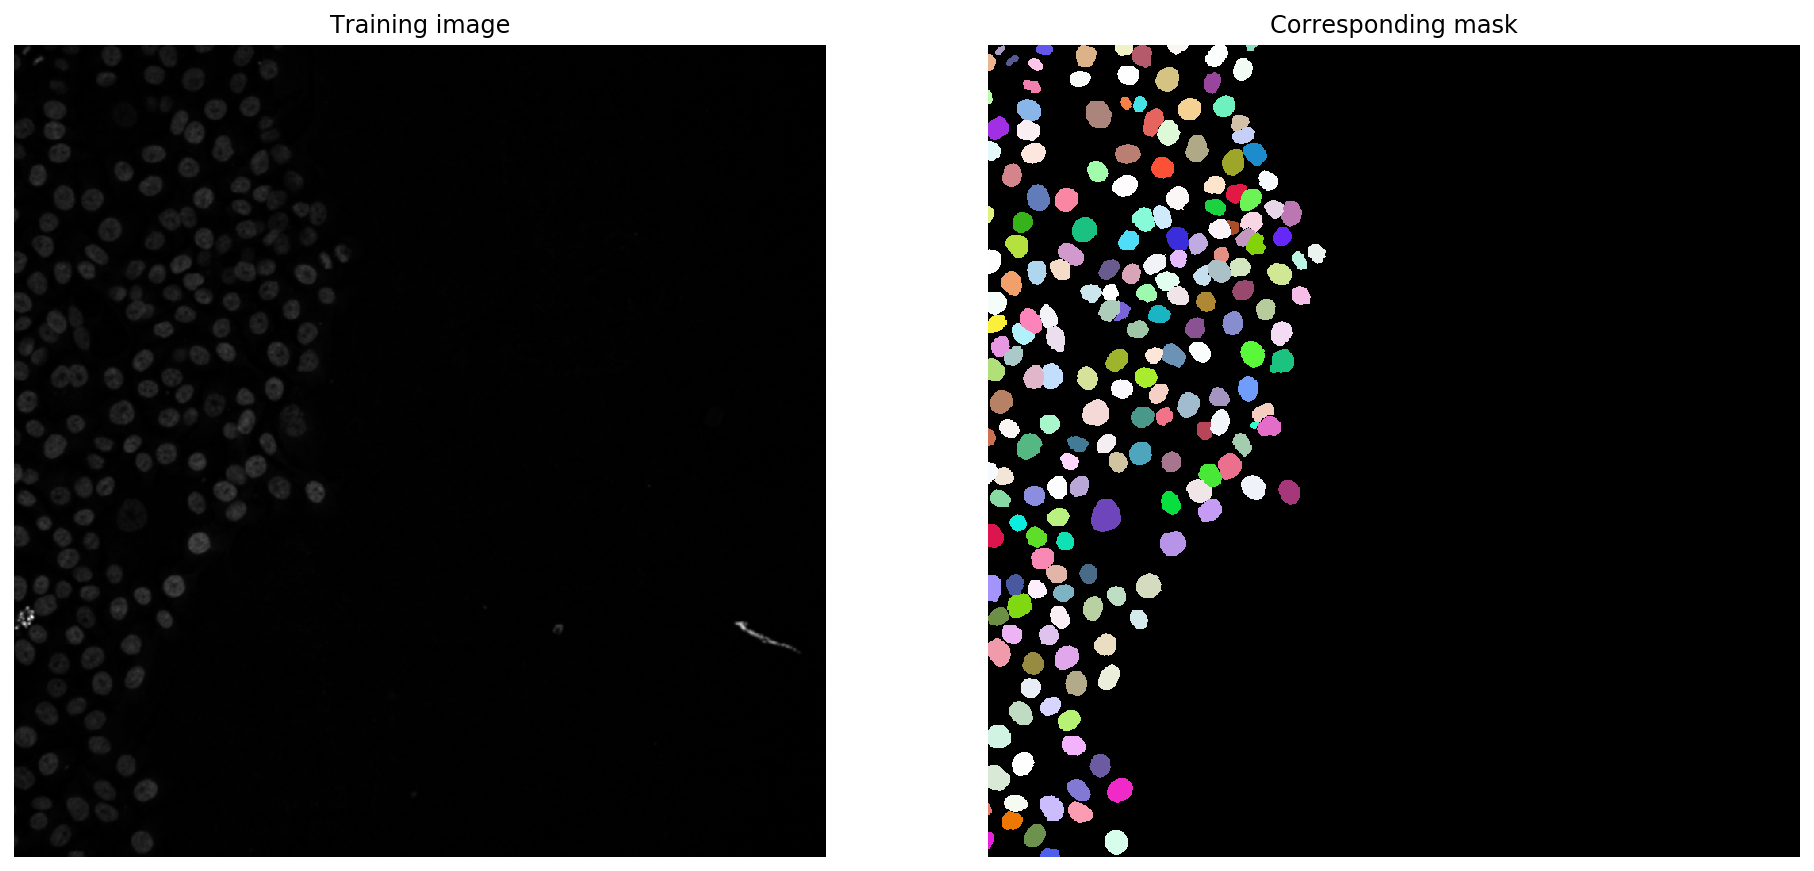

In [0]:
#@markdown ###Play the cell to show the images.
i = min(9, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if img.ndim==2 else img[...,:3]
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Training image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('Corresponding mask')
None;

### **4.3. Train the network**
<font size = 4>When playing the cell below you should see updates after each epoch (round). Network training can take some time. You can estimate the training time by following equation: 

<font size = 4>t(training) = ( t(s)/epoch *x* epochs)/60. 

<font size = 4>**For example:**

<font size = 4>**t(training) = (16 s/epoch x 400 epochs)/60 = 106,7 min**

<font size = 4>* **CRITICAL NOTE:** Google Colab has time limit for processing (to prevent using GPU power for datamining). Training time must be less than 12 hours! If training takes longer than 12 hours, please decrease the training parameters or training data.

In [0]:
#@markdown Play the cell to start network training.
augmenter = None

# def augmenter(X_batch, Y_batch):
#     """Augmentation for data batch.
#     X_batch is a list of input images (length at most batch_size)
#     Y_batch is the corresponding list of ground-truth label images
#     """
#     # ...
#     return X_batch, Y_batch

# Training the model. 
# 'input_epochs' and 'steps' refers to your input data in section 5.1 
history = model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                      epochs=input_epochs, steps_per_epoch=input_steps)
None;



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Epoch 1/50
50/50 [==============================] - 11s 223ms/step - loss: 2.2867 - prob_loss: 0.4042 - dist_loss: 9.4126 - prob_kld: 0.3098 - dist_relevant_mae: 9.4123 - dist_relevant_mse: 126.9523 - val_loss: 1.4528 - val_prob_loss: 0.2602 - val_dist_loss: 5.9634 - val_prob_kld: 0.1613 - val_dist_relevant_mae: 5.9626 - val_dist_relevant_mse: 58.4311

Epoch 2/50
50/50 [==============================] - 7s 145ms/step - loss: 1.2735 - prob_loss: 0.2330 - dist_loss: 5.2028 - prob_kld: 0.1455 - dist_relevant_mae: 5.2017 - dist_relev

### **4.4. Evaluate the training**



<font size = 4>It is good practice to evaluate the training progress by comparing the training loss with the validation loss. The latter is a metric which shows how well the network performs on a subset of unseen data which is set aside from the training dataset. For more information on this, see for example [this review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381354/) by Nichols *et al.*

<font size = 4>**Loss** <code>(loss)</code> describes an error value after each epoch for the difference between the model's prediction and its 'GT' target.

<font size = 4>**Validation error** <code>(val_loss)</code> describes the same error value between the model's prediction on a validation image (taken from 'low') and compared to it's target (from 'GT').

<font size = 4>During training both values should decrease before reaching a minimal value which does not decrease even after further training. Comparing the development of the validation error with the training error can give insights into the model's performance.

<font size = 4>If **validation error is clearly higher than training error**, it means that the training data might be too complex or diverse. In this case, the trained network fails to improve unseen images. To avoid this, increase the number of epochs and check if you can improve your dataset with more examples.

<font size = 4>If **validation error is clearly smaller than training error**, it means that training data is too simple which allows the network to learn the training data perfectly but to perform poorly on unseen data. This is called overfitting which should be always be avoided as it can lead to artefacts in the predctions of the network. First steps to avoid this can be to reduce the number of training epochs or to use a larger training dataset.

['dist_loss', 'dist_relevant_mae', 'dist_relevant_mse', 'loss', 'lr', 'prob_kld', 'prob_loss', 'val_dist_loss', 'val_dist_relevant_mae', 'val_dist_relevant_mse', 'val_loss', 'val_prob_kld', 'val_prob_loss']


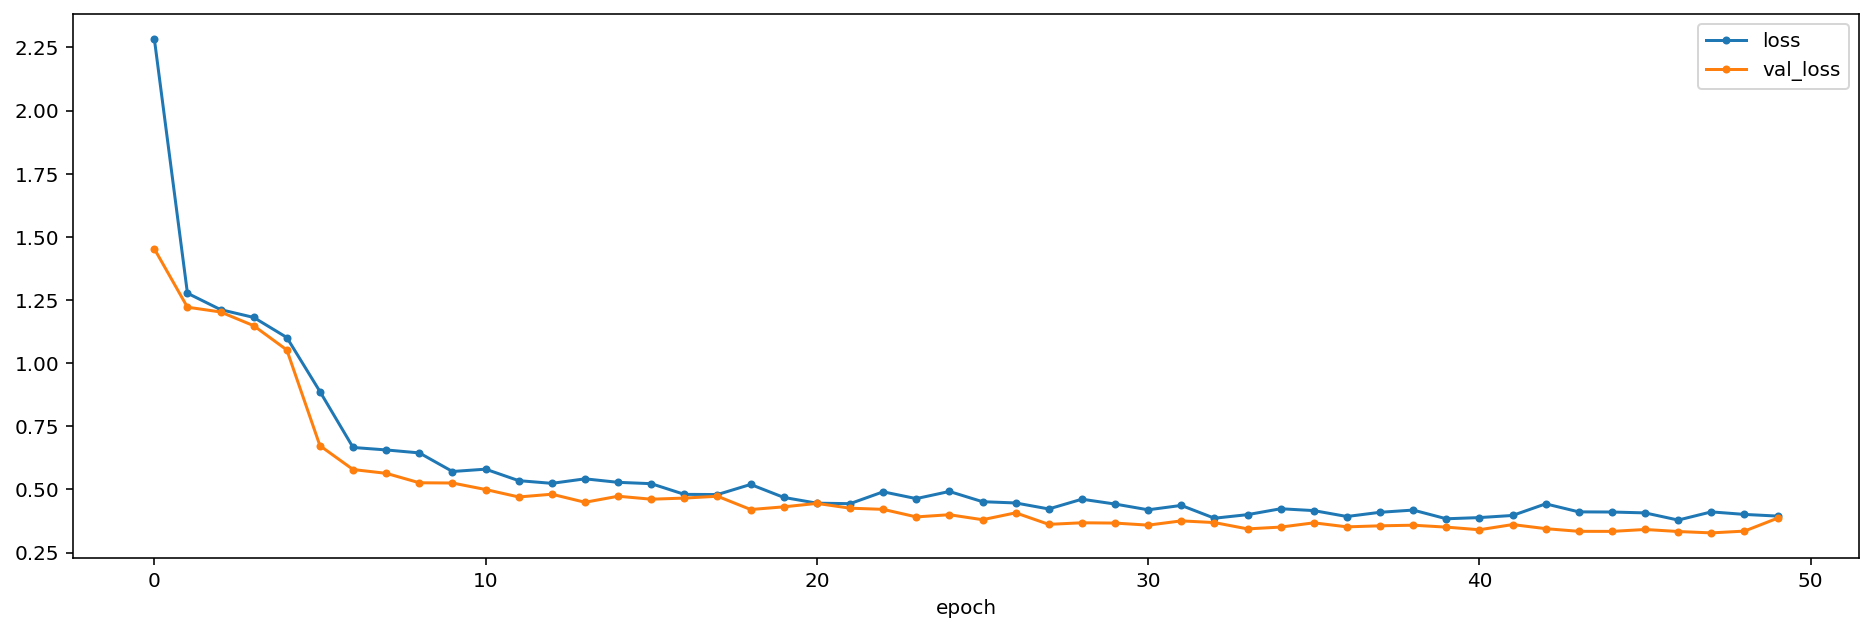

In [0]:
#@markdown ###Play the cell to show a figure of the training errors


import pandas as pd
import csv

# Sorts the results and prints headlines
print(sorted(list(history.history.keys())))

# Create figure framesize
errorfigure = plt.figure(figsize=(16,5))

# Choose the values you wish to compare. 
# For example, If you wish to see another values, just replace 'loss' to 'dist_loss'
plot_history(history,['loss','val_loss']); 

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# The figure is saved into content/ as test.csv (refresh the Files if needed). 
RESULTS = results+'/test.csv'
with open(RESULTS, 'w') as f:
    for key in hist_df.keys():
        f.write("%s,%s\n"%(key,hist_df[key]))




**4.5 Network optimization**
---
Here we optimaze non-maximum suppression (NMS).

The optimized values are saved into you model folder (see section 5.1) as  thresholds.json-file.

In [0]:
#@markdown Play the cell to optimize the network.
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:16<00:07,  1.46s/it, 0.519 -> 0.926]


Using optimized values: prob_thresh=0.516929, nms_thresh=0.5.
Saving to 'thresholds.json'.


{'nms': 0.5, 'prob': 0.5169294144791796}

# **5. Prediction of single images**
---
In this section we use the trained network on your test data. You will then be able to export ROI that you can then open in imageJ / Fiji


**5.1 Load your data and a trained network**
---


In [0]:
#@markdown Play this cell to load your data and a trained network
np.random.seed(16)
lbl_cmap = random_label_cmap()

X = sorted(glob(test_dataset))
X = list(map(imread,X))

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

model = StarDist2D(None, name=model_name, basedir=trained_model)

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.516929, nms_thresh=0.5.


**5.2 Test your network on one image**
---

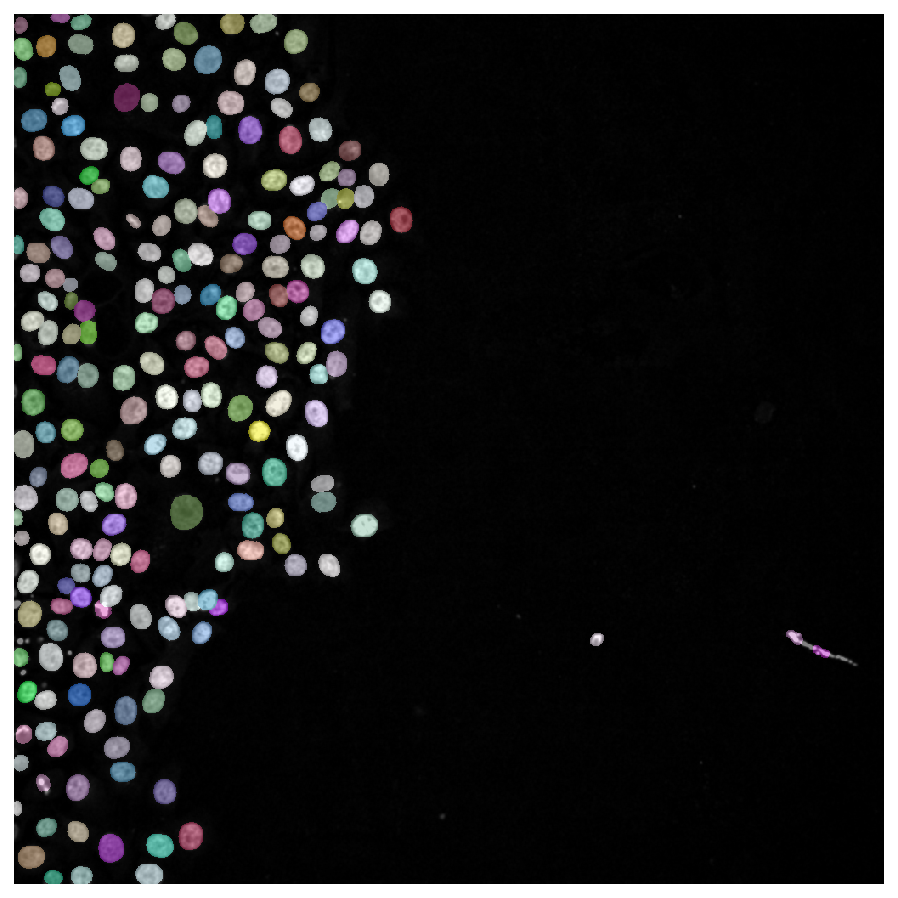

In [0]:
#@markdown Play this cell to preview one prediction for a test image.
my_images = len(X)-1
img = normalize(X[my_images], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)

plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,:3], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');


**5.3 Predict all your images and export the ROI**
---

All the ROIs will be saved into your results folder. 

In [0]:
#@markdown ##Play this cell to predict all your images and export the ROI.
#Sorting and mapping original test dataset
X = sorted(glob(test_dataset))
X = list(map(imread,X))

# collect the names of test images
names = [os.path.basename(f) for f in sorted(glob(test_dataset))]

# modify the names to suitable form: path_images/image_numberX.tif
FILEnames=[]
for m in names:
  m=results+'/'+m
  FILEnames.append(m)

# Save all ROIs into results folder
lenght_of_X = len(X)
for i in range(lenght_of_X):
  img = normalize(X[i], 1,99.8, axis=axis_norm)
  labels, polygons = model.predict_instances(img)
  export_imagej_rois(FILEnames[i], polygons['coord'])

#polygons = [model.predict_instances(frame)[1]['coord'] for frame in tqdm(timelapse)]

# **5.4. Store your results**

---
**Copy your folder tree ** and ALL its results elsewhere and after that clean the original folder tree (datasets, results, trained model etc.) if you plan to train or use new networks. Please note that notebook will **OVERWRITE** all files which have the same name.

# **6. Prediction of stacks**
---
In this section we use a trained network to predict stacks (xyt, for instance live-cell imaging)

**6.1 Load your data and a trained network**
---


In [0]:
#@markdown ##Play this cell to load your data and a trained network
np.random.seed(42)
lbl_cmap = random_label_cmap()

Y = sorted(glob(test_dataset))
X = list(map(imread,Y))

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

#Load a pretrained network
model = StarDist2D(None, name=model_name, basedir=trained_model)


Normalizing image channels independently.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.516929, nms_thresh=0.5.


**6.2 Predict all your images and export the ROI**
---
Here you can batch process a folder of stacks.

All the ROIs will be saved into your results folder. 



In [0]:
#@markdown ##Play this cell to predict all your images and export the ROI.

# Getting the current work directory (test_batch)
names = [os.path.basename(f) for f in sorted(glob(test_dataset))]

thisdir = Path(testDATA)
outputdir = Path(results)

# Save all ROIs and images in Results folder.
for num, i in enumerate(X): 
  timelapse = np.stack(i)
  timelapse = normalize(timelapse, 1,99.8, axis=(0,)+tuple(1+np.array(axis_norm)))
  timelapse.shape
  polygons = [model.predict_instances(frame)[1]['coord'] for frame in tqdm(timelapse)]
   
  save_tiff_imagej_compatible(os.path.join(outputdir, names[num]), timelapse, axes='TYX')
  export_imagej_rois(os.path.join(outputdir, names[num]), polygons)

100%|██████████| 86/86 [00:34<00:00,  2.18it/s]


# **6.3. Store your results**

---
**Copy your folder tree ** and ALL its results elsewhere and after that clean the original folder tree (datasets, results, trained model etc.) if you plan to train or use new networks. Please note that notebook will **OVERWRITE** all files which have the same name.

##**Thank you for using Stardist!**